In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.integrate import simpson

In [2]:
# Constants
NA = 6.02214076E23  # Avogadro's number

In [3]:
def compute_c_profile(xvg_file):
    """
    Computes a concentration profile from an XVG file by averaging symmetric parts of the profile.

    Parameters
    ----------
    xvg_file : str
        The path to the XVG file containing the number density data.
    
    Returns
    -------
    z_coords : numpy.ndarray
        The z-coordinates of the concentration profile.
    c_profile : numpy.ndarray
        The symmetric concentration profile.
    """
    z_coords, rho = np.loadtxt(xvg_file, comments=["@", "#"], unpack=True)
    # rho = rho / NA * 1E27 / 1000  # number density in mol/L

    mid_idx = int(len(rho) / 2 - 1)
    c_profile = 0.5 * (rho[:mid_idx + 1][::-1] + rho[mid_idx:-1])  # in mol/L
    z_coords = z_coords[:mid_idx + 1]  # in nm

    return z_coords, c_profile


## bootstrap for uncertainities

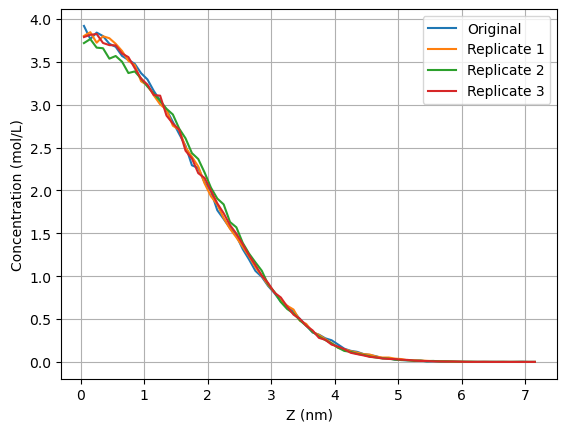

In [4]:
z_0, c_0 = compute_c_profile("density_hwl.xvg")
z_1, c_1 = compute_c_profile("density_hwr1.xvg")  # replicate 1
z_2, c_2 = compute_c_profile("density_hwr2.xvg")  # replicate 2
z_3, c_3 = compute_c_profile("density_hwr3.xvg")  # replicate 3

# Plot the concentration profiles
plt.figure()
plt.plot(z_0, c_0, label="Original")
plt.plot(z_1, c_1, label="Replicate 1")
plt.plot(z_2, c_2, label="Replicate 2")
plt.plot(z_3, c_3, label="Replicate 3")
plt.xlabel("Z (nm)")
plt.ylabel("Concentration (mol/L)")
plt.grid()
plt.legend()


In [5]:
# Estimate the total number of ions, N_s (using Equation 13)
L_x, L_y, L_z = 4.8, 4.8, 14.4
N_s = L_x * L_y * simpson(c_0, z_0)
print(N_s)  # this should be around 188

187.74314794646403


/tmp/ipykernel_92404/2582005041.py:3: DeprecationWarning: You are passing x=[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35
 1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45 5.55
 5.65 5.75 5.85 5.95 6.05 6.15 6.25 6.35 6.45 6.55 6.65 6.75 6.85 6.95
 7.05 7.15] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  N_s = L_x * L_y * simpson(c_0, z_0)


In [49]:
def calc_y(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    B, alpha_1, alpha_2 = theta[0], theta[1], theta[2]  # all nm-based
    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = A * np.sqrt(C_max) / (1 + B * np.sqrt(C_max))
    term_3 = -A * np.sqrt(x) / (1 + B * np.sqrt(x))
    term_4 = (alpha_1 * (x - C_max)) + (alpha_2 * (x ** 2 - C_max ** 2))

    y = term_1 + term_2 + term_3 + term_4

    return y

In [50]:
def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

In [51]:
# Removing 0 values from the concentration profile, and the corresponding z values
z_0 = z_0[c_0 != 0]
c_0 = c_0[c_0 != 0]

# Calculating -U(z) / RT (y_values below)
k = 1.0457  # units: kJ/mol/nm^2
R = 8.31446261815324  # units: J/(mol*K)
T = 300  # units: K
y_values = -(0.5 * k * z_0 ** 2) * 1000 / (R * T)

result = least_squares(residuals, [2, 0.1, 0.1], args=(c_0, y_values))

# B, alpha_1, and alpha_2 have units of [nm^(-3)]^(-1/2), [nm^(-3)]^(-1), and [nm^(-3)]^(-2)
B, alpha_1, alpha_2 = result.x[0], result.x[1], result.x[2]

# Converting nm^(-3) to mol/L for the three parameters
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
B *= (conversion_factor ** (-0.5))  # units M^(-1/2)
alpha_1 *= (conversion_factor ** (-1))  # units M^(-1)
alpha_2 *= (conversion_factor ** (-2))  # units M^(-2)


In [52]:
result.x

array([ 3.45410721,  0.51187678, -0.07764156])

In [53]:
print(B, alpha_1, alpha_2)
newtheta=(B, alpha_1, alpha_2)

2.6804719315812147 0.3082594028192992 -0.02815762701802209


In [54]:
result.cost

17.499845689070508

In [55]:
result.optimality

0.007965782189614856

In [56]:
# nm-based answers
print(1.9247 / (conversion_factor ** (-0.5)))
print(9.3393E-2 / (conversion_factor ** (-1)))
print(3.4572E-2 / (conversion_factor)**(-2))

2.4802050938626055
0.15508272510056706
0.09532848685910528


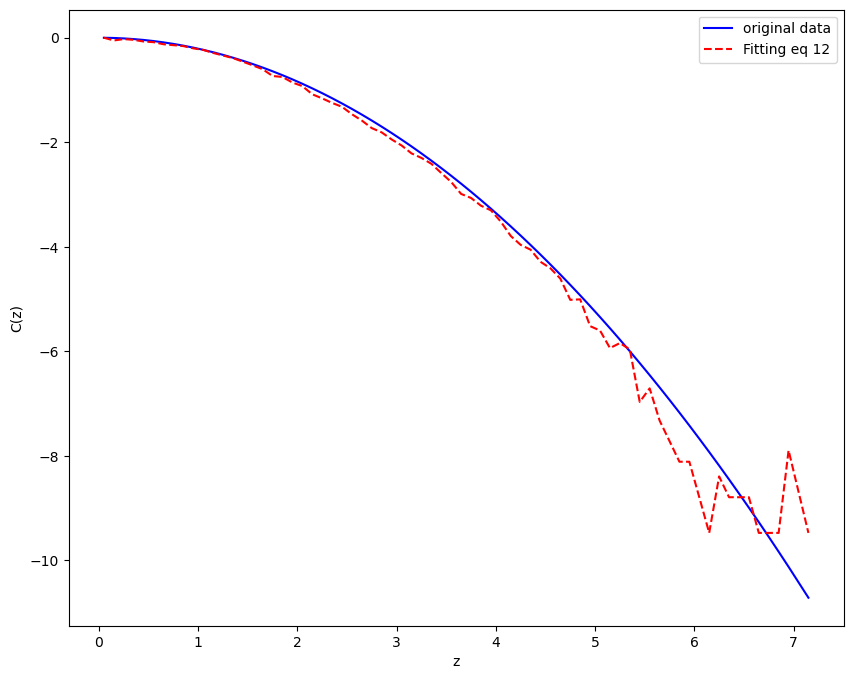

In [57]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_0, y_values, 'b', label="original data")
plt.plot(z_0, calc_y(newtheta,c_0), 'r--', label="Fitting eq 12")
plt.xlabel('z')
plt.ylabel('C(z)')
plt.legend()
plt.show()